In [1]:
using Pkg
Pkg.activate("..")
#Pkg.develop(["Equilibrium", "IMAS"])
using Revise
using FUSE
using FUSE.IMAS
using Plots

  Activating environment at `~/Coding/julia/FUSE/Project.toml`
┌ Info: Precompiling FUSE [e64856f0-3bb8-4376-b4b7-c03396503992]
└ @ Base loading.jl:1317


 19.874910 seconds (93.71 M allocations: 4.972 GiB, 5.80% gc time)
SolovevEquilibrium
  B0 = 5.3 [T]
  R0 = 6.2 [m]
  ϵ  = 0.32
  δ  = 0.33
  κ  = 1.7
  α  = 1.1215785773538434e-5
  q⋆ = 1.5453256126187265
  βp = 0.9101993127394403
  βt = 0.03902981154997272
  σ  = 1
  diverted  = true
  xpoint  = (5.479808, -3.7100800000000005)
  symmetric = false


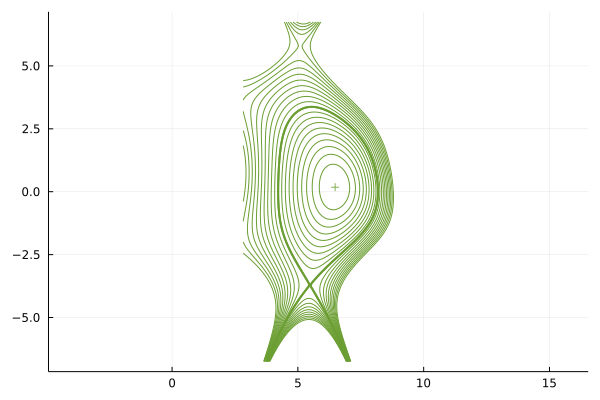

In [2]:
ϵ = 0.32
κ = 1.7
δ = 0.33
R0 = 6.2
B0 = 5.3
ip = 15.E6
beta_n = 3.0
x_point=true
symmetric=true

resolution = 129

eq0=IMAS.equilibrium()
FUSE.init(eq0, 0.0; B0, R0, ϵ, δ, κ, beta_n, ip, x_point=x_point)

eqactor = FUSE.SolovevEquilibriumActor(eq0, 0.0, alpha=1, qstar=1.5,symmetric=symmetric)
@time FUSE.step(eqactor)
eq1 = FUSE.finalize(eqactor, resolution, (R0*(1-ϵ*1.7), R0*(1+ϵ*2)), (-R0*ϵ*κ*2, R0*ϵ*κ*2))

println(eqactor.S)

eqt = eq1.time_slice[1];
plot(eqt)

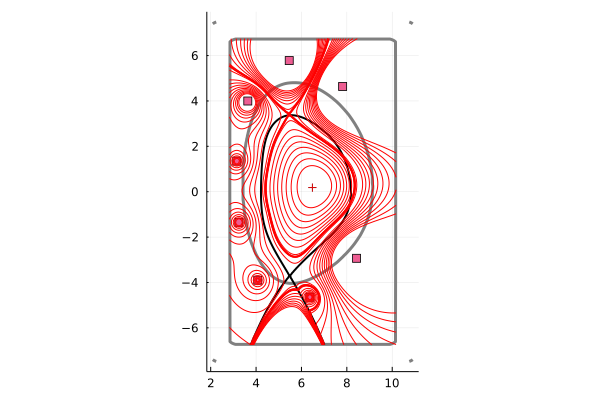

 * Status: failure (exceeded time limit of 30.0)

 * Candidate solution
    Final objective value:     5.060367e-02

 * Found with
    Algorithm:     Nelder-Mead

 * Convergence measures
    √(Σ(yᵢ-ȳ)²)/n ≰ 1.0e-08

 * Work counters
    Seconds run:   30  (vs limit 30)
    Iterations:    5610
    f(x) calls:    7844



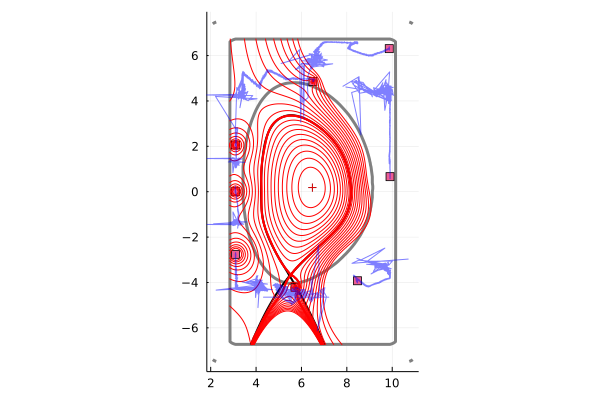

In [58]:
pfoptactor = PFcoilsOptActor(eq1, 0.0, 8, 3);
display(plot(pfoptactor))

step(pfoptactor, λ_currents=1E7, verbose=true, symmetric=false)
display(plot(pfoptactor))

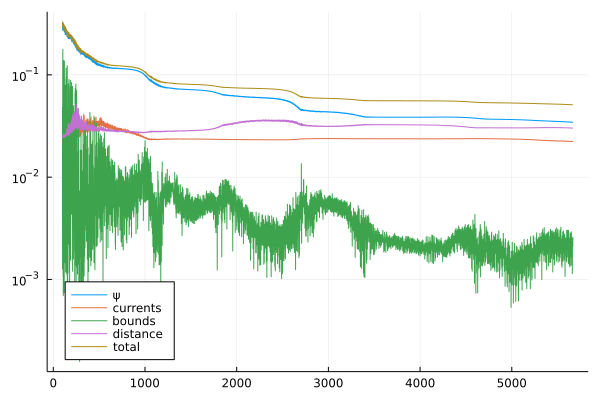

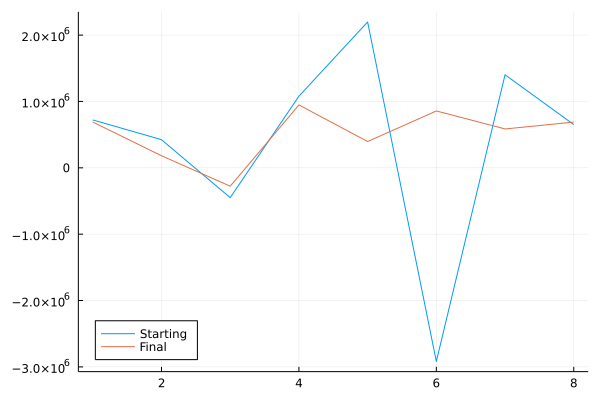

In [57]:
display(plot(pfoptactor.trace,:cost,start_at=100))

display(plot(pfoptactor.trace,:currents))
